# Initial EDA

In this notebook, I am going to bring in the data from Quantiacs, then split it into a training dataset (I need to keep my system from snooping into the future, so will leave some data unexplored). Then, the training data will be explored to look for useful patterns or relationships from which ideas and expectations might be generated.

## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import qnt.data as qndata
import qnt.xr_talib as xrtl
import xarray as xr
import xarray.ufuncs as xruf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pandas_datareader import data
import tensorflow as tf

## Import Data from Quantiacs

In [6]:
# get as much data as possible (there is less that 50 years of data)
data = qndata.futures_load_data(tail=356*50)
data

<xarray.DataArray 'futures' (field: 7, time: 8072, asset: 75)>
array([[[7.73000e-01,         nan,         nan, ...,         nan,
                 nan, 9.17700e+01],
        [7.68900e-01,         nan,         nan, ...,         nan,
                 nan, 9.17400e+01],
        [7.70800e-01,         nan,         nan, ...,         nan,
                 nan, 9.17800e+01],
        ...,
        [7.74400e-01, 6.81900e+02, 8.57000e+01, ..., 3.24700e+03,
         3.27540e+04, 9.99300e+01],
        [7.80450e-01, 6.84700e+02, 8.52000e+01, ..., 3.24200e+03,
         3.29150e+04, 9.99325e+01],
        [7.74150e-01, 6.76050e+02, 8.35000e+01, ..., 3.23100e+03,
         3.27780e+04, 9.99325e+01]],

       [[7.74000e-01,         nan,         nan, ...,         nan,
                 nan, 9.17700e+01],
        [7.70300e-01,         nan,         nan, ...,         nan,
                 nan, 9.17700e+01],
        [7.76100e-01,         nan,         nan, ...,         nan,
                 nan, 9.17900e+01],
...
        [3.77000e+02, 3.20110e+04, 3.83870e+04, ..., 1.33880e+04,
         8.65560e+04, 1.14453e+05],
        [3.90000e+02, 3.20110e+04, 3.83190e+04, ..., 1.36370e+04,
         9.04830e+04, 1.17849e+05],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[0.00000e+00,         nan,         nan, ...,         nan,
                 nan, 0.00000e+00],
        [0.00000e+00,         nan,         nan, ...,         nan,
                 nan, 0.00000e+00],
        [0.00000e+00,         nan,         nan, ...,         nan,
                 nan, 0.00000e+00],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 1990-01-02 1990-01-03 ... 2021-03-19
  * asset    (asset) object 'F_AD' 'F_AE' 'F_AH' 'F_AX' ... 'F_XX' 'F_YM' 'F_ZQ'
  * field    (field) object 'open' 'high' 'low' 'close' 'vol' 'oi' 'roll'

In [7]:
data.shape

(7, 8072, 75)

The data comes in as an `xarray`, which I guess is like a numpy array but with named dimensions, columns, and rows. 

The dimensions are:

* **field** - the fields are, in order, Open, High, Low, Close, Volume, Open Interest (OI), and Rollover Info (roll)
* **time** - the data is daily, from 1990-01-02 to yesterday (2021-03-08)
* **asset** - there are 75 futures contracts in the data. I am honestly not sure what they are...but I will find out later on. 

I am now going to separate the data by field into DataFrames.

In [8]:
open_df = data.sel(field='open').to_pandas()
high_df = data.sel(field='high').to_pandas()
low_df = data.sel(field='low').to_pandas()
close_df = data.sel(field='close').to_pandas()
vol_df = data.sel(field='vol').to_pandas()
oi_df = data.sel(field='oi').to_pandas()
roll_df = data.sel(field='roll').to_pandas()

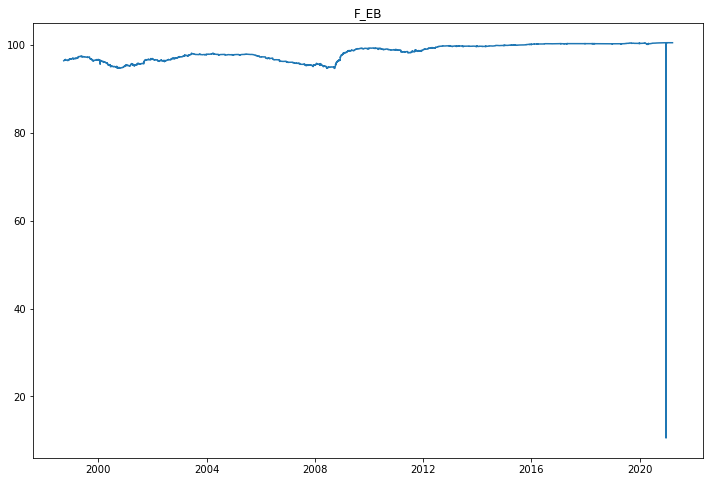

In [9]:
# I am now going to check plots of every single one of the futures contracts. All plots will not be left visible, but ones with anomalies will be left here.
plt.figure(figsize=(12,8))
plt.plot(open_df.iloc[:,18])
plt.title(open_df.columns[18]);

Above is the Eurex 3-month Euribor interest rate future. It has a very unexpected downward spike in late 2020. Let's investigate.

In [10]:
open_df['F_EB']['2020-12-20':'2021-01-01']

time
2020-12-21    100.540
2020-12-22     10.535
2020-12-23    100.535
2020-12-24        NaN
2020-12-28    100.535
2020-12-29    100.535
2020-12-30    100.535
2020-12-31        NaN
Name: F_EB, dtype: float64

Ah. This looks like a typo. On 2020-12-22, the price was entered as 10.535 when it probably should have been 100.535, as it is for the rest of the year. Let's change that data point.

In [11]:
open_df.loc['2020-12-22','F_EB'] = 100.535
high_df.loc['2020-12-22','F_EB'] = 100.535
low_df.loc['2020-12-22','F_EB'] = 100.535
close_df.loc['2020-12-22','F_EB'] = 100.535
open_df['F_EB']['2020-12-20':'2021-01-01']

time
2020-12-21    100.540
2020-12-22    100.535
2020-12-23    100.535
2020-12-24        NaN
2020-12-28    100.535
2020-12-29    100.535
2020-12-30    100.535
2020-12-31        NaN
Name: F_EB, dtype: float64

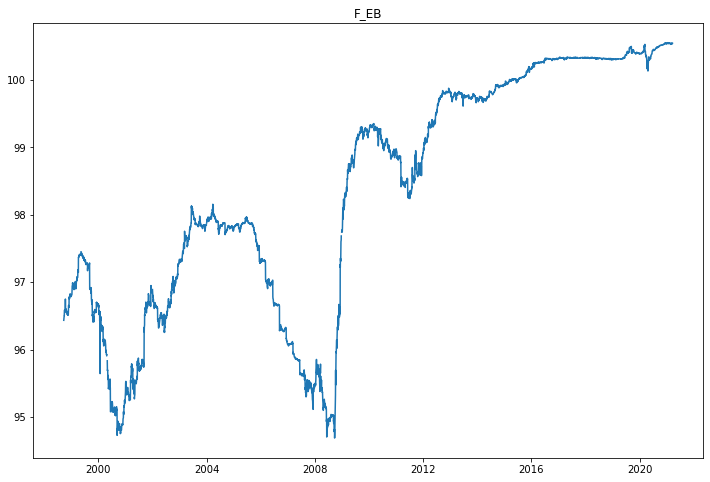

In [12]:
plt.figure(figsize=(12,8))
plt.plot(open_df.iloc[:,18])
plt.title(open_df.columns[18]);

Much better. Moving on.

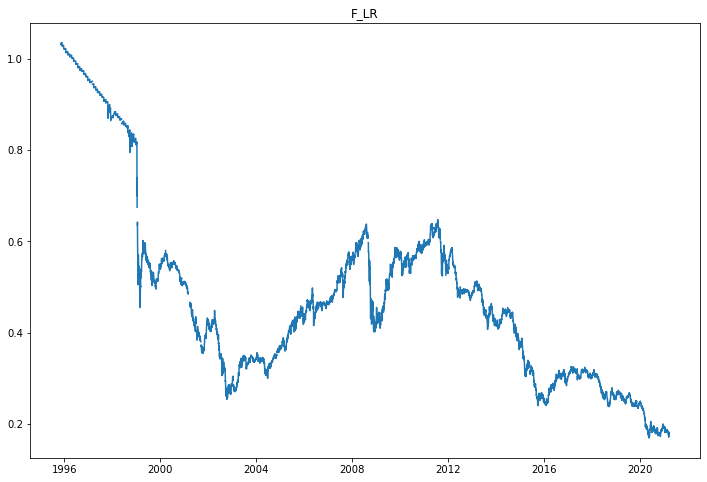

In [13]:
plt.figure(figsize=(12,8))
plt.plot(open_df.iloc[:,38])
plt.title(open_df.columns[38]);

Above is the price series for Brazilean Real futures. It has a sharp dip and a gap in 1999. Let's investigate.

In [14]:
open_df['F_LR']['1999-01-10':'1999-02-20']

time
1999-01-11    0.8141
1999-01-12    0.8100
1999-01-13    0.7000
1999-01-14    0.7400
1999-01-15    0.6750
1999-01-18       NaN
1999-01-19    0.6350
1999-01-20    0.6425
1999-01-21    0.6200
1999-01-22    0.5895
1999-01-25    0.5700
1999-01-26    0.5250
1999-01-27    0.5250
1999-01-28    0.5145
1999-01-29    0.5050
1999-02-01    0.5100
1999-02-02    0.5410
1999-02-03    0.5700
1999-02-04    0.5445
1999-02-05    0.5430
1999-02-08    0.5464
1999-02-09    0.5200
1999-02-10    0.5380
1999-02-11    0.5340
1999-02-12    0.5330
1999-02-15       NaN
1999-02-16    0.5295
1999-02-17    0.5225
1999-02-18    0.5405
1999-02-19    0.5280
Name: F_LR, dtype: float64

There are just a couple of NaN values messing up the plot. The intense drop in futures prices in 1999 comes from the decision by Brazil's national bank to devalue its currency. The move caused panic in markets around the world. It was a big deal.

We can fix the problems here by using a simple fillna with method='ffill', which does not introduce look-ahead bias (because it uses only past values). Then we will taket he pct_change of the dataframe and drop the NaN values. This will still leave over 3,000 data points to work with.

In [15]:
open_df_ffill = open_df.fillna(method='ffill')
high_df_ffill = high_df.fillna(method='ffill')
low_df_ffill = low_df.fillna(method='ffill')
close_df_ffill = close_df.fillna(method='ffill')
vol_df_ffill = vol_df.fillna(method='ffill')
oi_df_ffill = oi_df.fillna(method='ffill')
roll_df_ffill = roll_df.fillna(method='ffill')

open_df_pct = open_df_ffill.pct_change().dropna()
high_df_pct = high_df_ffill.pct_change().dropna()
low_df_pct = low_df_ffill.pct_change().dropna()
close_df_pct = close_df_ffill.pct_change().dropna()


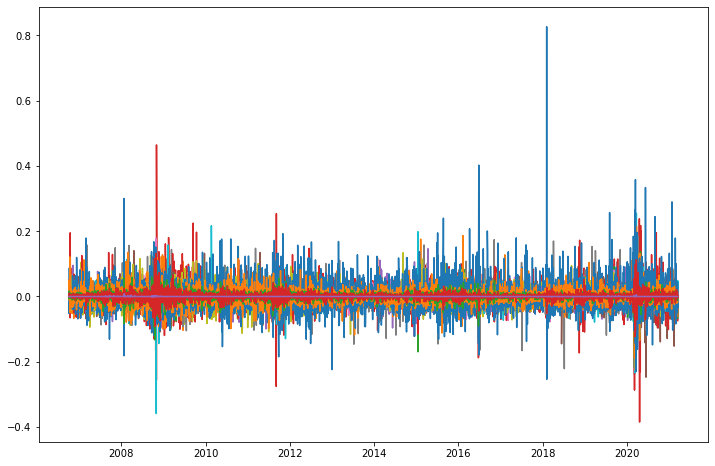

In [16]:
plt.figure(figsize=(12,8))
plt.plot(open_df_pct);

There are some pretty big spikes still in there, but it should be fine to use for modeling.

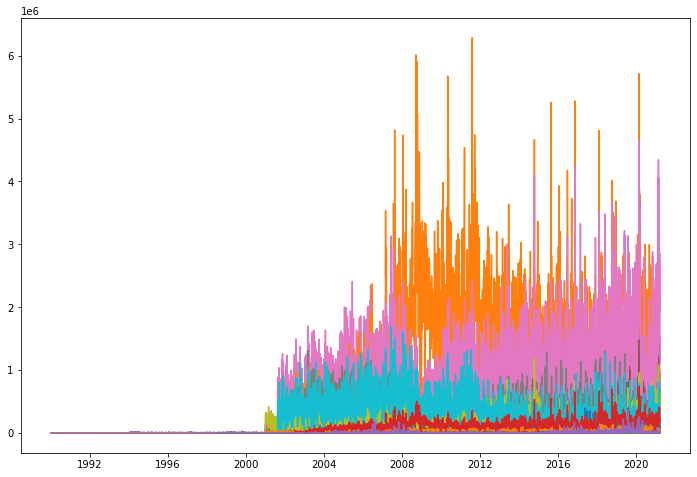

In [17]:
# do we need to take the pct_change for volume?
plt.figure(figsize=(12,8))
plt.plot(vol_df_ffill);

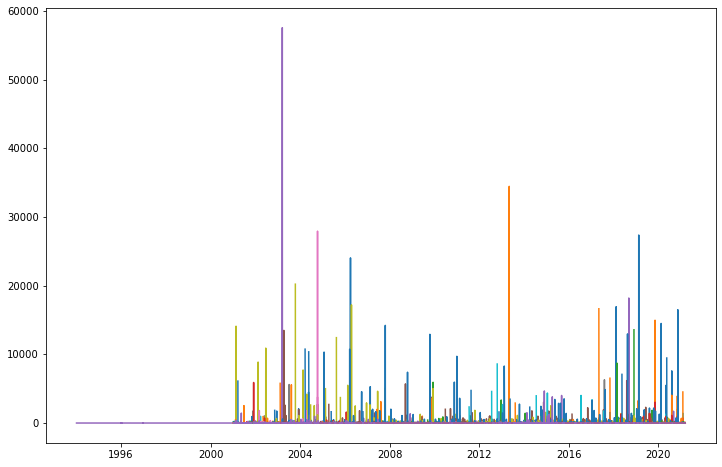

In [18]:
plt.figure(figsize=(12,8))
plt.plot(vol_df_ffill.pct_change());

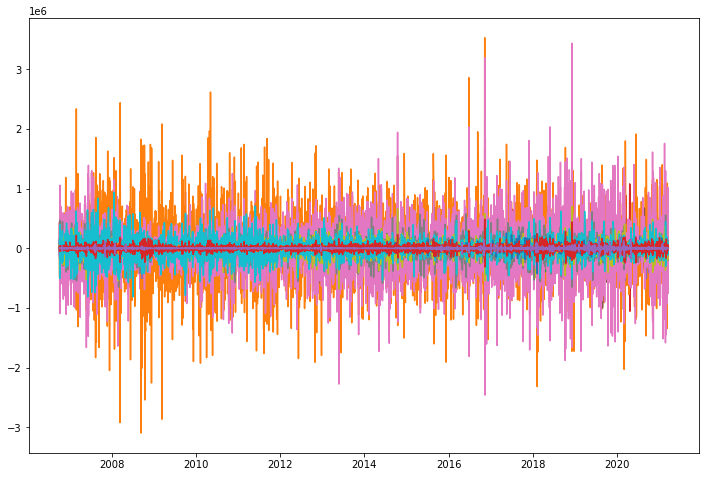

In [19]:
# diff looks way better
vol_df_diff = vol_df_ffill.diff().dropna()
plt.figure(figsize=(12,8))
plt.plot(vol_df_diff);

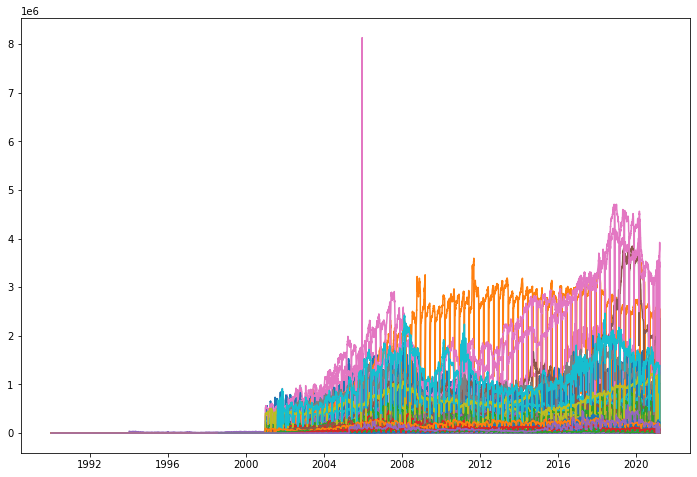

In [20]:
# what about oi?
plt.figure(figsize=(12,8))
plt.plot(oi_df_ffill);

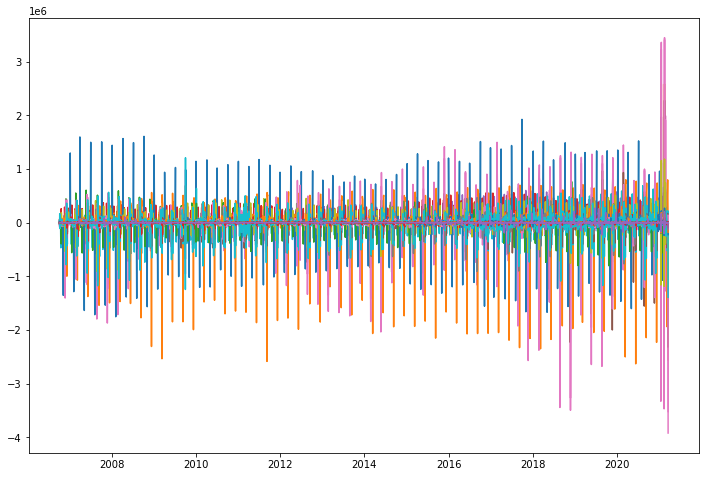

In [21]:
oi_df_diff = oi_df_ffill.diff().dropna()
plt.figure(figsize=(12,8))
plt.plot(oi_df_diff);

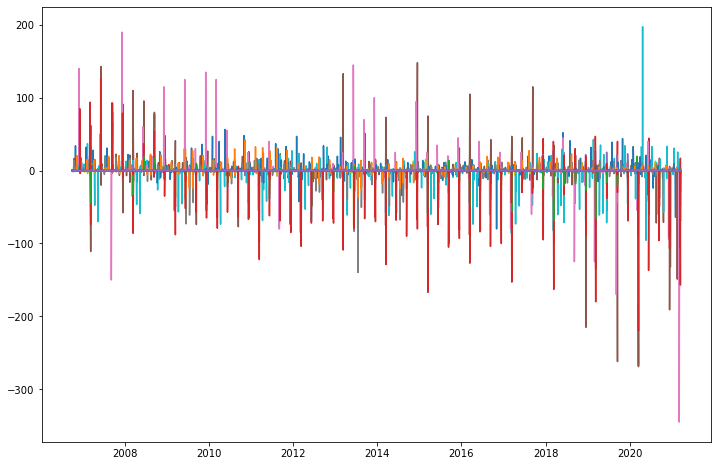

In [22]:
# what about the rollover data?
plt.figure(figsize=(12,8))
plt.plot(roll_df_ffill.dropna());

In [23]:
# looks fine. Just drop the NaN values.
roll_df_use = roll_df_ffill.dropna()

## Prepare the dataset for the model

What should we use as features to predict the next day's open price?

Since we are predicting Open prices, we need to use all other features (prices, open interest, volume, rollover info) from one day before. The easiest way to handle this is to actually use the Open Price from one day ahead...let's make that dataframe now.

In [24]:
next_day_open = open_df_pct.shift(-1).dropna()
next_day_open

asset,F_AD,F_AE,F_AH,F_AX,F_BC,F_BG,F_BO,F_BP,F_C,F_CA,...,F_TU,F_TY,F_UB,F_US,F_UZ,F_VX,F_W,F_XX,F_YM,F_ZQ
time,,,,,,,,,,,,,,,,,,,,,
2006-10-03,-0.006961,0.003634,0.008349,0.003488,-0.038646,-0.032199,-0.012500,0.000106,-0.012161,-0.000382,...,-0.000382,-0.000722,-0.001363,-0.001110,-0.000481,0.000000,-0.010644,0.000844,0.004346,0.000000
2006-10-04,0.003775,0.009725,0.012739,0.016221,0.022677,0.021863,0.004641,-0.000212,0.034091,0.013273,...,0.001604,0.003755,0.001820,0.004443,0.000721,-0.051852,0.050963,0.016587,0.010182,0.000000
2006-10-05,-0.000134,-0.002869,0.007547,-0.003013,0.007223,0.005581,0.009240,-0.003972,-0.007326,-0.002262,...,-0.001144,-0.003022,-0.000636,-0.004976,-0.000384,0.087500,0.003233,-0.005254,0.001680,0.000000
2006-10-06,0.000000,-0.004213,0.021223,-0.000490,0.004837,0.005088,0.006658,0.000000,0.000923,-0.002361,...,0.000000,0.000000,-0.000909,0.000000,0.000048,0.007902,0.003759,0.000278,-0.000922,0.000000
2006-10-09,-0.001209,0.008668,-0.015892,0.002370,0.000498,0.006443,0.033072,-0.006328,0.063594,0.004166,...,-0.001909,-0.006206,-0.001092,-0.008058,-0.000529,-0.019957,0.121455,0.007504,0.000755,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12,-0.003788,-0.008353,-0.010405,0.002197,-0.007329,0.002729,0.010219,-0.003644,-0.000930,0.004398,...,-0.000177,-0.004954,-0.000518,-0.011706,-0.000089,-0.017408,-0.009320,-0.011960,0.010127,0.000000
2021-03-15,0.000258,0.005468,0.001168,-0.006783,-0.003909,-0.011791,-0.003432,-0.002725,0.023277,-0.000661,...,-0.000106,0.001185,0.001482,0.003814,0.000134,-0.049213,0.012152,0.003104,0.003790,0.000000
2021-03-16,-0.002126,0.002205,0.000000,0.004415,-0.006104,-0.004130,0.000544,-0.000575,0.008189,-0.002398,...,0.000071,-0.000592,-0.000370,-0.002000,-0.000134,-0.006211,0.001162,0.004641,-0.002619,0.000000


Now let's put all of the features together: open_df_pct, vol_df_diff, oi_df_diff, and roll_df_use. Everything is still ordered by date, so it should be easy to put together. 

In [25]:
features = pd.merge(open_df_pct, vol_df_diff, how='inner', left_index=True, right_index=True)
features = pd.merge(features, oi_df_diff, how="inner", left_index=True, right_index=True)
features = pd.merge(features, roll_df_use, how="inner", left_index=True, right_index=True)

In [26]:
features.describe()

asset,F_AD_x,F_AE_x,F_AH_x,F_AX_x,F_BC_x,F_BG_x,F_BO_x,F_BP_x,F_C_x,F_CA_x,...,F_TU_y,F_TY_y,F_UB_y,F_US_y,F_UZ_y,F_VX_y,F_W_y,F_XX_y,F_YM_y,F_ZQ_y
count,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,...,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000
mean,0.000046,0.000182,-0.000114,0.000342,0.000258,0.000157,0.000309,-0.000060,0.000354,0.000134,...,-0.003045,-0.013042,-0.005194,-0.012904,-0.000986,0.036578,0.269529,-0.285714,-0.597913,0.000257
std,0.008365,0.013632,0.010746,0.014493,0.022588,0.019234,0.014059,0.006250,0.017828,0.014103,...,0.038952,0.121606,0.129017,0.293583,0.025737,0.486217,2.303188,3.472467,8.550010,0.022485
min,-0.079351,-0.111486,-0.094708,-0.128480,-0.238209,-0.155432,-0.078947,-0.103501,-0.115805,-0.110045,...,-0.851562,-2.281250,-1.990000,-1.625000,-0.555000,-17.030000,-1.750000,-68.000000,-137.000000,-0.217510
25%,-0.003844,-0.005459,-0.005739,-0.005705,-0.010675,-0.009933,-0.007839,-0.003211,-0.008796,-0.005925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000129,0.000567,0.000000,0.000730,0.000431,0.000000,0.000000,0.000000,0.000000,0.000629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.004466,0.006514,0.005659,0.007139,0.011445,0.010109,0.008462,0.003271,0.009303,0.006847,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.081167,0.107236,0.060000,0.112908,0.187318,0.113911,0.067996,0.029426,0.151683,0.119130,...,0.257812,0.640625,1.640000,15.437500,0.415000,6.400000,42.250000,23.000000,126.000000,0.810000


### How to shape the data for the model

Okay. The model we are going to use to predict price movements will be a multi-step, multi-series CNN-LSTM. It will take in 2 5-day weeks (10 days) of each of the 300 predictive features (input shape `(1, 2, 5, 300)`). As a first model architecture, we will try a Convolutional Layer, then MaxPooling, then two LSTM layers, and a Dense output layer. There will probably be more layers added later and then include dropout layers and other regularization. It will predict 4 days ahead, which will give us 4 predictions for each new day.

But for now, we need a way to cut the features DataFrame into a `(n_obs, 2, 5, 300)` array.

In [206]:
def split_sequences(features, target, days_per_group=5, groups=2, future_days=4):
    X, y = list(), list()
    for i in range(len(features)):
        end_ix = i + (days_per_group * groups)
        out_end_ix = end_ix + future_days
        
        if out_end_ix >= len(features):
            break
        
        seq_X = features.iloc[i:end_ix, :]
        scaled_X = seq_X.copy()
        for col in range(seq_X.shape[1]):
            colmean = np.nanmean(seq_X.iloc[:,col])
            colstd = np.nanstd(seq_X.iloc[:,col])
            
            if colstd == 0:
                colstd = 1
            elif math.isnan(colstd):
                colstd = 1
            scaled_X.iloc[:,col] = (seq_X.iloc[:,col] - colmean) / colstd
        scaled_X = scaled_X.fillna('ffill')
        scaled_X = scaled_X.fillna(0)
            
        seq_y = target.iloc[end_ix:out_end_ix, :].copy()
        seq_y = seq_y.fillna('ffill')
        seq_y = seq_y.fillna(0)
        
        X.append(scaled_X)
        y.append(seq_y)
        
    X = np.array(X)
    X = X.reshape(X.shape[0], groups, days_per_group, features.shape[1])
        
    y = np.array(y)
    y = np.stack(y)
    
    return X, y

In [207]:
X, y = split_sequences(features, next_day_open, days_per_group=5, groups=2, future_days=4)

In [208]:
y.shape

(3724, 4, 75)

In [209]:
X.shape

(3724, 2, 5, 300)

### Split into training, validation, and test sets

One of the best things about preparing the data the way we did just above is that we have erased the date information, so there can be no date-related rules (which are not allowed in Quantiacs competitions). Now, we need to split the data into three groups:

* We will use the training data to train the model
* We will use the validation data to check the accuracy of the model and develop the trading system
* We will use the test data to test the trading system

We will use 2213 observations for training, 756 for validation, and 756 for testing. That's 3 years of trading days for each of the validation and test sets.

In [413]:
X_train = X[:2213]
X_valid = X[2213:(2213+756)]
X_test = X[(2213+756):]

y_train = y[:2213]
y_valid = y[2213:(2213+756)]
y_test = y[(2213+756):]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1], X_valid.shape[2], X_valid.shape[3])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3])

In [414]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2213, 1, 2, 5, 300) (2213, 4, 75)
(756, 1, 2, 5, 300) (756, 4, 75)
(755, 1, 2, 5, 300) (755, 4, 75)


In [32]:

features_test = features.iloc[(-756):, :]
features_valid = features.iloc[-(756+756):-756, :]
features_train = features.iloc[-(756+756+2213):-(756+756), :]

In [33]:
open_df_pct_test = open_df_pct.iloc[(-756):, :]
open_df_pct_valid = open_df_pct.iloc[-(756+756):-756, :]
open_df_pct_train = open_df_pct.iloc[-(756+756+2213):-(756+756), :]

In [34]:
open_df_test = open_df.iloc[(-756):, :]
open_df_valid = open_df.iloc[-(756+756):-756, :]
open_df_train = open_df.iloc[-(756+756+2213):-(756+756), :]

## Check for Correlations

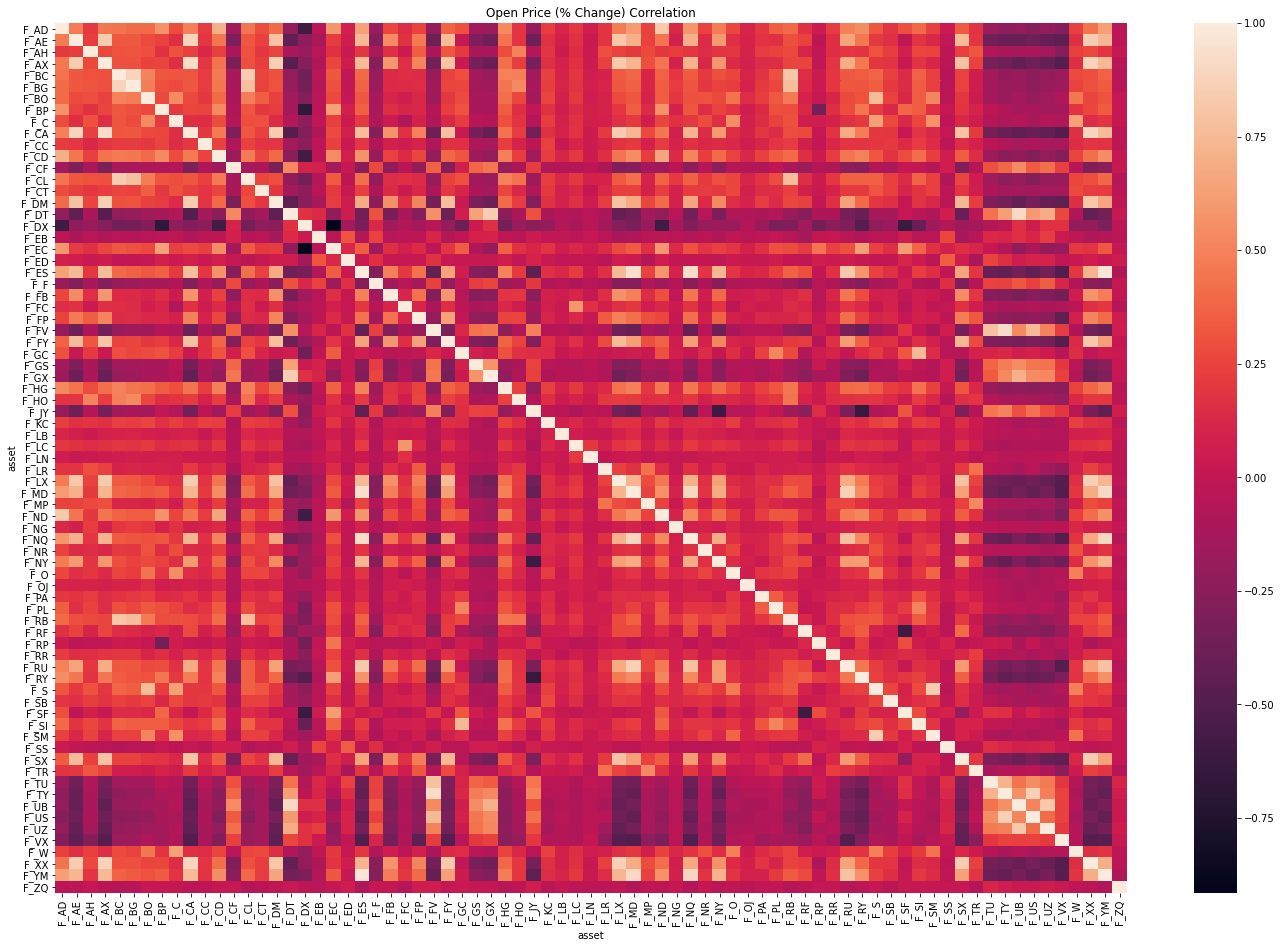

In [35]:
cormat_train = open_df_pct_train.corr()
plt.figure(figsize=(24,16))
sns.heatmap(cormat_train)
plt.title('Open Price (% Change) Correlation');

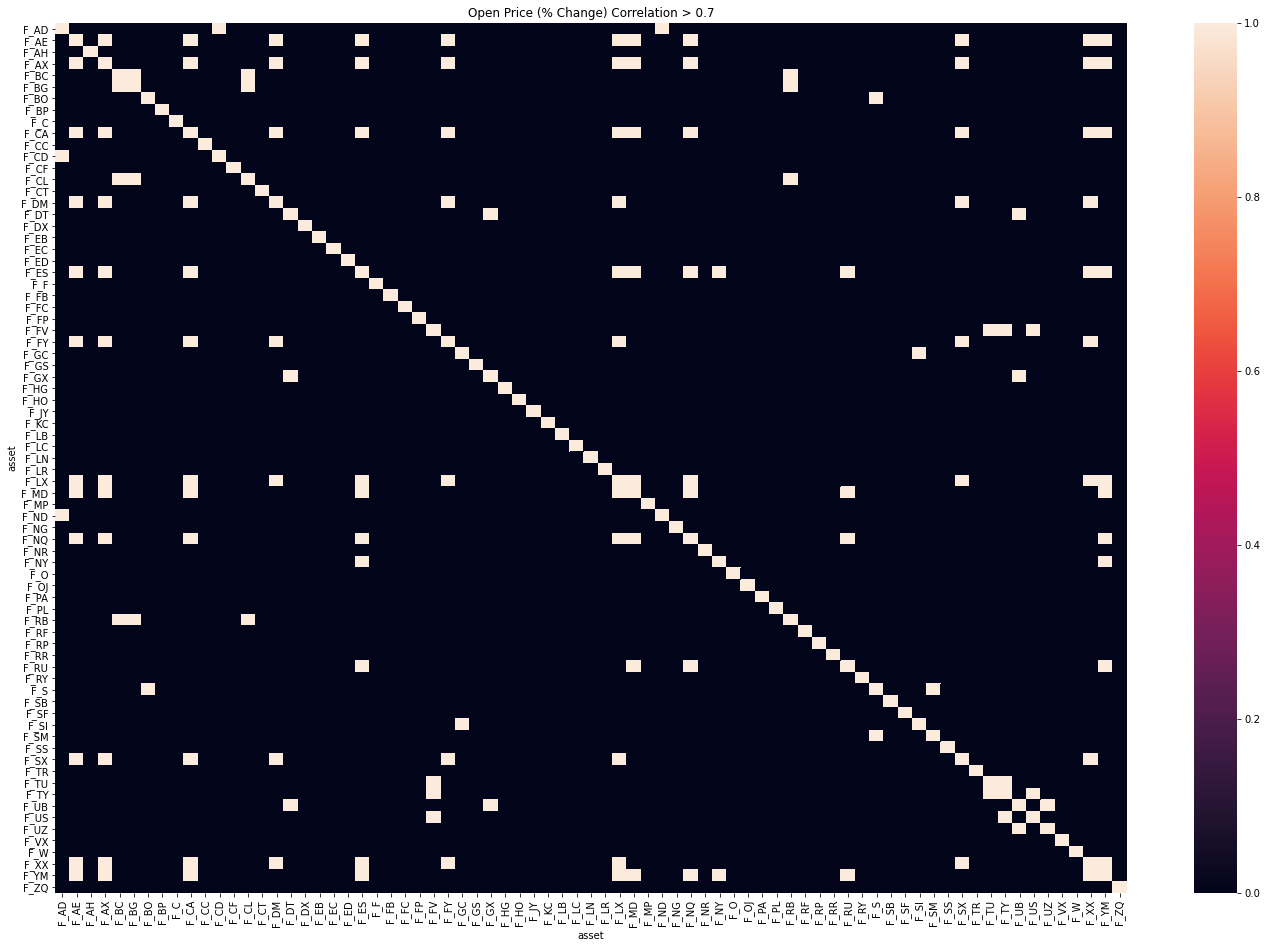

In [36]:
cormat_train = open_df_pct_train.corr()
plt.figure(figsize=(24,16))
sns.heatmap(cormat_train > 0.7)
plt.title('Open Price (% Change) Correlation > 0.7');

There are quite a few futures with strong positive correlations. Modern Portfolio Theory implies that we should go long in some of these and short in others. This correlation should also be useful in the predictive model. Let's see how strong the correlation gets.

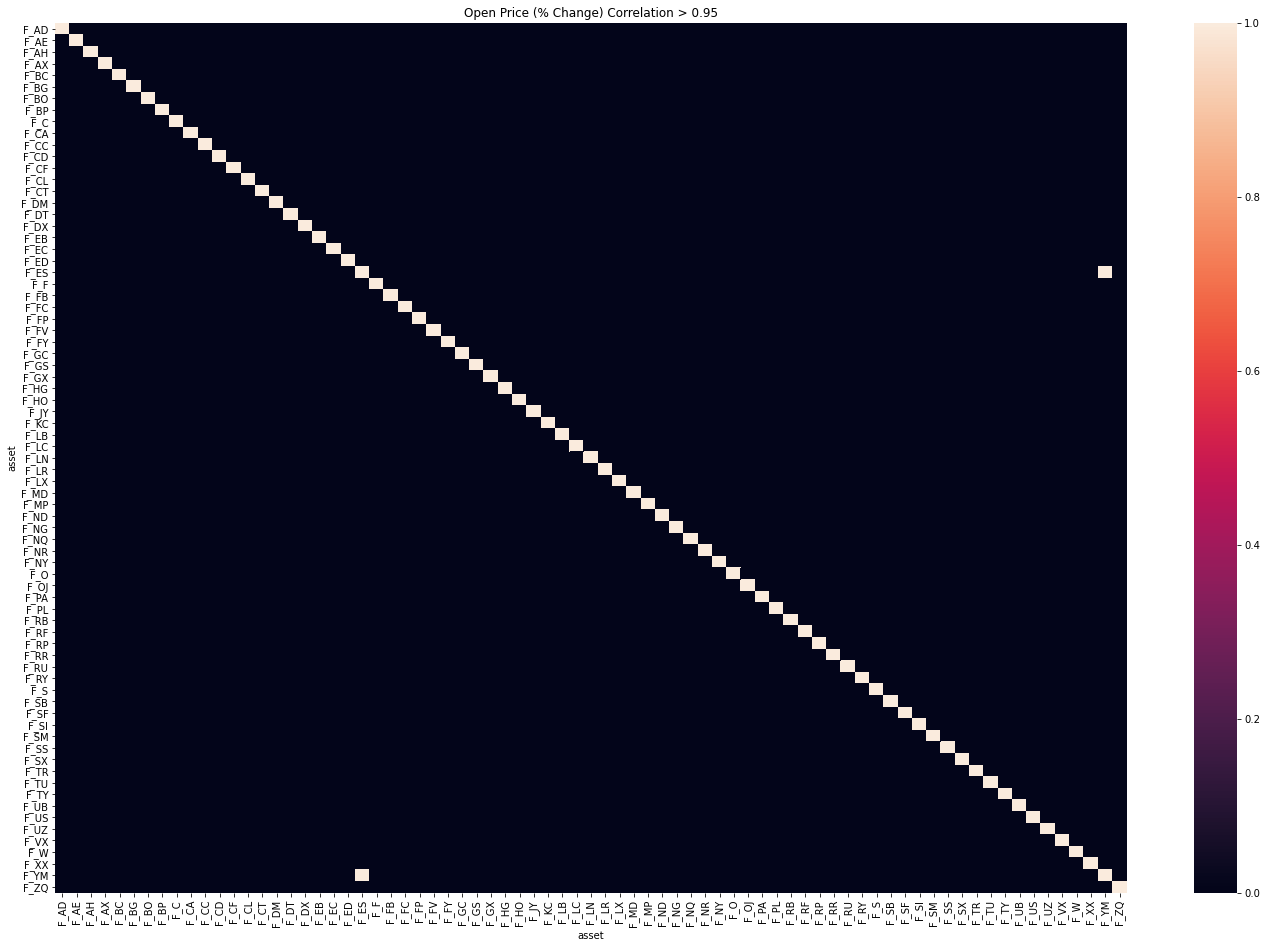

In [37]:
plt.figure(figsize=(24,16))
sns.heatmap(cormat_train > 0.95)
plt.title('Open Price (% Change) Correlation > 0.95');

**F_ES** and **F_YM** have a correlation coefficient higher than 0.99! That's very, very strong. Those are futures on the S&P 500 E-Mini and the Dow Futures Mini. It makes sense that they are strongly correlated, but 0.95 is pretty extreme.

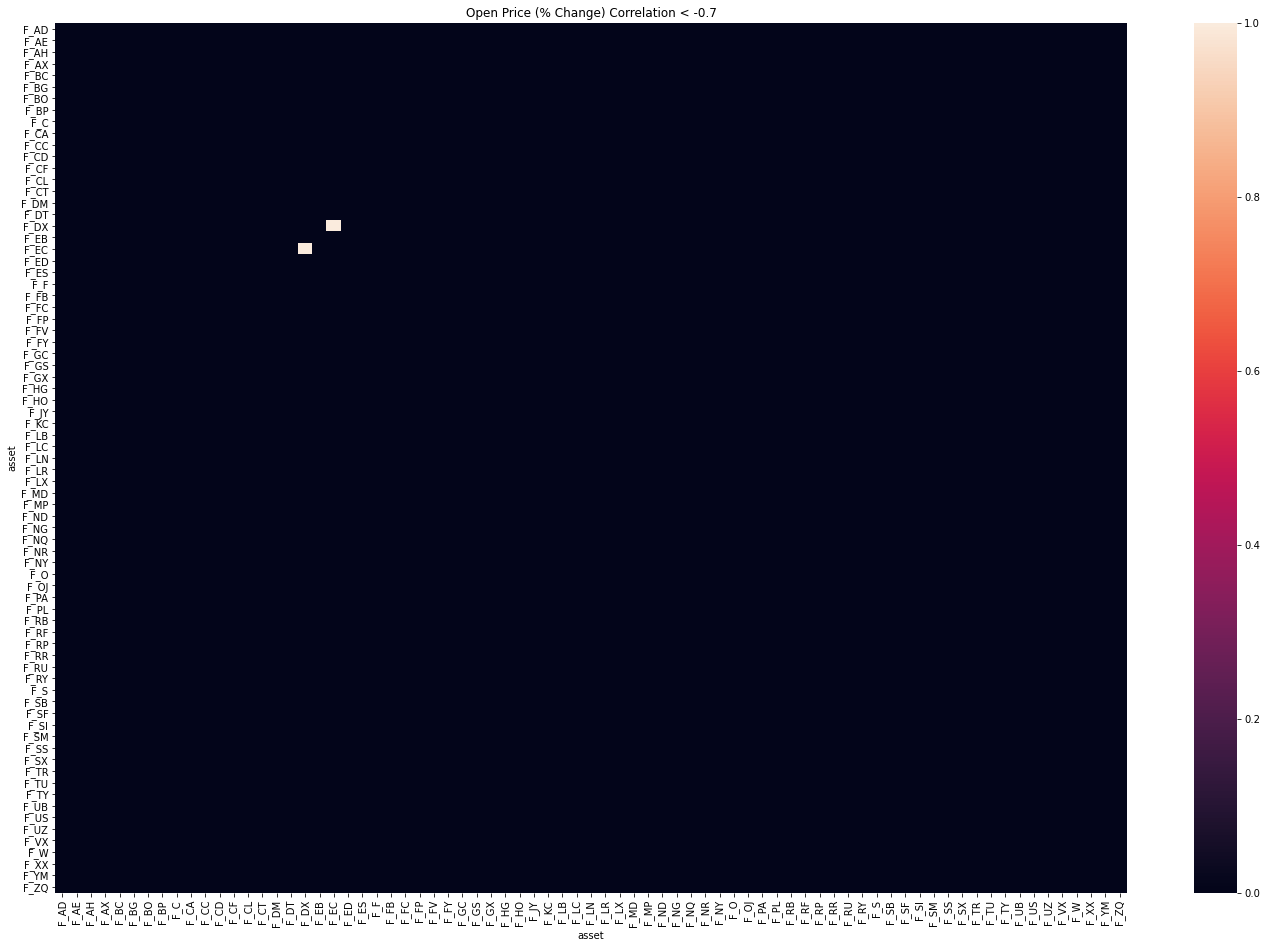

In [38]:
plt.figure(figsize=(24,16))
sns.heatmap(cormat_train < -0.7)
plt.title('Open Price (% Change) Correlation < -0.7');

There is only one pair with a strong negative correlation: **F_DX**, the US Dollar Index future, and **F_EC**, the Euro FX future. Most financial assets tend to be positively correlated, because the market tends to rise and fall together. It is rare for two assets to be strongly negatively correlated, so the fact that there is only one pair is not surprising. It is good, though, for portfolio construction. 

Let's lastly look at assets with very low correlation.

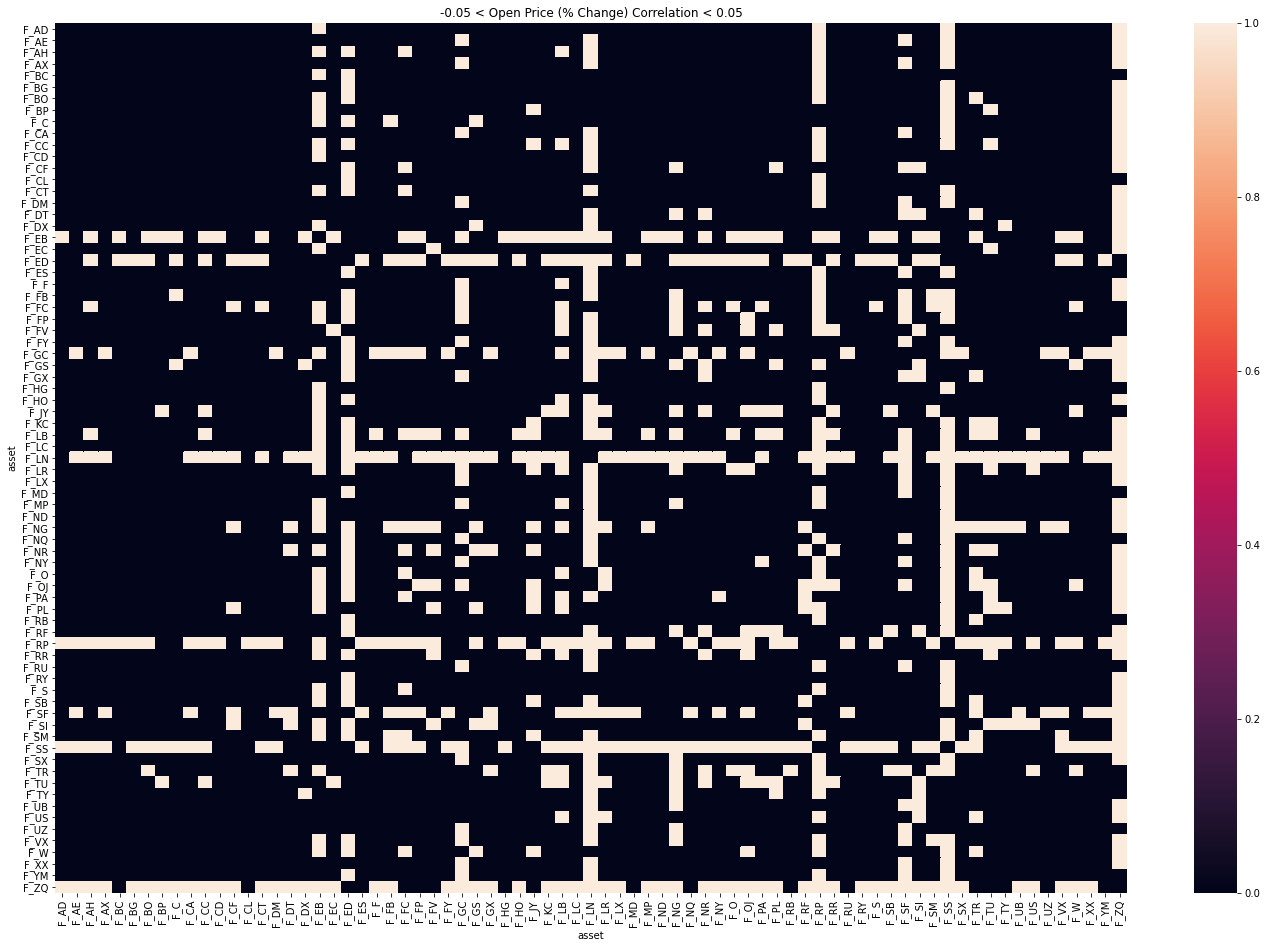

In [39]:
plt.figure(figsize=(24,16))
sns.heatmap(abs(cormat_train) < 0.05)
plt.title('-0.05 < Open Price (% Change) Correlation < 0.05');

Quite a few futures have correlation in $(-0.05, 0.05)$. **F_ZQ**, 30-Day Fed Funds, is uncorrelated with almost all other futures. Futures with mostly weak correlation are:

* **F_EB** - Eurex 3-Month Euribor
* **F_ED** - Eurodollar
* **F_LN** - Lean Hogs
* **F_SS** - 3-Month Sterling
* **F_ZQ** - 30-Day Fed Funds

Notable mention: **F_RP**, Euro/Pound.

Interestingly, the uncorrelated futures are mostly currency-based, with the exception of the 30-Day Fed Funds and the strangest of them all: Lean Hogs. 

Let's see just how weak the correlation gets.

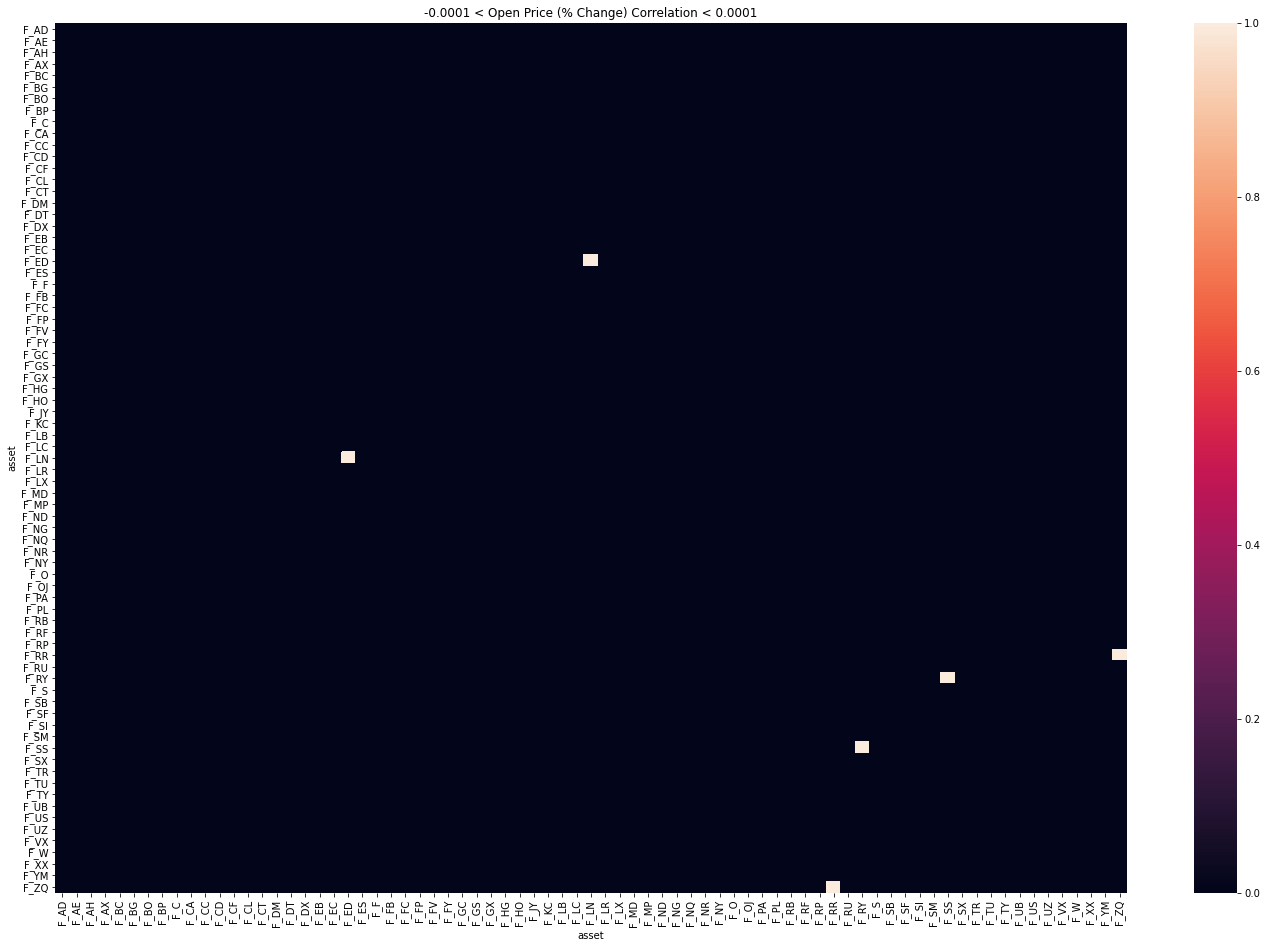

In [40]:
plt.figure(figsize=(24,16))
sns.heatmap(abs(cormat_train) < 0.001)
plt.title('-0.0001 < Open Price (% Change) Correlation < 0.0001');

There are three pairs with correlation in $(-0.001, 0.001)$:
    
* **F_LN** and **F_ED** - Lean Hogs and Eurodollar
* **F_RY** and **F_SS** - Euro/Yen and 3-Month Sterling
* **F_RR** and **F_ZQ** - Russian Rubles and 30-Day Fed Funds

## Modern Portfolio Theory Optimization

We are going to use the more traditional methods of Modern Portfolio Theory on the training data to find the optimal allocation weights for the highest Sharpe ratio.

In [41]:
# use log-returns, because they are additive rather than multiplicative
log_price_train = open_df_pct_train.apply(lambda x: np.log(1+x))
log_price_train.head(10)

asset,F_AD,F_AE,F_AH,F_AX,F_BC,F_BG,F_BO,F_BP,F_C,F_CA,...,F_TU,F_TY,F_UB,F_US,F_UZ,F_VX,F_W,F_XX,F_YM,F_ZQ
time,,,,,,,,,,,,,,,,,,,,,
2006-10-20,0.004365,0.007858,-0.005401,0.005314,0.025109,-0.010134,0.022138,0.005124,0.003170,0.006246,...,-0.000460,-0.001751,-0.000639,-0.002822,-0.000289,-0.004773,0.001949,0.007607,0.002408,0.000000
2006-10-23,0.000264,-0.002443,-0.002410,0.004807,-0.034014,-0.005106,-0.011772,0.002924,-0.014343,0.005468,...,-0.000077,-0.000438,-0.000548,-0.000283,-0.000433,-0.024214,-0.013726,0.001622,-0.000083,0.000053
2006-10-24,-0.002643,0.003052,-0.003020,0.002873,-0.003043,-0.005132,0.014411,-0.005375,0.020652,0.003137,...,-0.000844,-0.002486,-0.001922,-0.005101,-0.000530,-0.030695,0.021002,0.001620,0.005953,-0.000053
2006-10-25,0.002247,-0.000102,0.014415,0.000080,0.014788,0.017618,0.001505,-0.000320,0.021004,-0.002029,...,0.000153,0.000586,0.000183,0.001420,0.000048,0.005042,0.016775,-0.001890,0.003292,0.000000
2006-10-26,0.003426,0.004865,0.011856,0.006038,0.037648,0.020469,-0.000376,0.002772,0.003842,0.004054,...,0.000767,0.003506,0.000275,0.005939,0.000096,-0.036709,-0.018710,0.007807,0.001396,0.000053
2006-10-27,0.004070,-0.003646,0.002942,0.002294,-0.021105,-0.018174,0.016782,0.006474,0.003063,0.003121,...,0.000843,0.003058,0.000183,0.004783,-0.000145,-0.008734,-0.013652,-0.005917,0.000164,0.000000
2006-10-30,0.005749,-0.013999,-0.011820,-0.009608,0.004093,-0.005978,0.014320,0.003168,0.009132,-0.013658,...,0.001148,0.002759,0.001738,0.004481,0.000385,0.003503,-0.004428,-0.010849,-0.004687,0.000000
2006-10-31,0.000391,0.002364,-0.010158,0.003743,-0.040516,-0.031868,-0.001824,0.001580,-0.002275,-0.001302,...,-0.000153,0.000145,0.000639,0.000837,0.000096,-0.007898,-0.009413,-0.000546,-0.000990,0.000000
2006-11-01,0.006490,-0.001952,0.004195,0.001827,0.001360,-0.000476,-0.021411,0.004674,-0.026155,-0.003168,...,0.001224,0.004051,0.002007,0.006678,0.000626,-0.011520,-0.033404,0.003541,-0.000330,0.000000


In [42]:
# find covariance matrix
covmat_train = log_price_train.cov()
covmat_train.head()

asset,F_AD,F_AE,F_AH,F_AX,F_BC,F_BG,F_BO,F_BP,F_C,F_CA,...,F_TU,F_TY,F_UB,F_US,F_UZ,F_VX,F_W,F_XX,F_YM,F_ZQ
asset,,,,,,,,,,,,,,,,,,,,,
F_AD,0.000092,0.000067,0.000024,0.000067,0.000085,0.000067,0.000060,0.000034,0.000056,0.000071,...,-0.000002,-0.000009,-0.000005,-0.000019,-0.000002,-0.000110,0.000051,0.000060,0.000073,-1.137451e-07
F_AE,0.000067,0.000222,0.000039,0.000193,0.000101,0.000086,0.000064,0.000023,0.000047,0.000201,...,-0.000006,-0.000025,-0.000015,-0.000040,-0.000006,-0.000278,0.000054,0.000181,0.000134,-9.545042e-08
F_AH,0.000024,0.000039,0.000135,0.000049,0.000072,0.000064,0.000053,0.000013,0.000073,0.000044,...,-0.000001,-0.000005,-0.000003,-0.000009,-0.000001,-0.000132,0.000062,0.000046,0.000027,1.958015e-08
F_AX,0.000067,0.000193,0.000049,0.000237,0.000095,0.000080,0.000060,0.000024,0.000051,0.000218,...,-0.000005,-0.000025,-0.000016,-0.000042,-0.000006,-0.000310,0.000055,0.000195,0.000141,-1.553129e-07
F_BC,0.000085,0.000101,0.000072,0.000095,0.000410,0.000308,0.000157,0.000040,0.000129,0.000102,...,-0.000003,-0.000019,-0.000009,-0.000036,-0.000004,-0.000140,0.000124,0.000087,0.000092,-3.495246e-07


In [43]:
# correlation matrix
cormat_train = log_price_train.corr()
cormat_train

asset,F_AD,F_AE,F_AH,F_AX,F_BC,F_BG,F_BO,F_BP,F_C,F_CA,...,F_TU,F_TY,F_UB,F_US,F_UZ,F_VX,F_W,F_XX,F_YM,F_ZQ
asset,,,,,,,,,,,,,,,,,,,,,
F_AD,1.000000,0.469086,0.211354,0.456121,0.437255,0.406326,0.405802,0.572001,0.287154,0.484087,...,-0.170764,-0.230493,-0.196457,-0.271338,-0.197769,-0.276312,0.240894,0.433032,0.622569,-0.042735
F_AE,0.469086,1.000000,0.227466,0.842961,0.336061,0.332844,0.282403,0.248681,0.157609,0.881425,...,-0.367789,-0.392369,-0.404924,-0.370277,-0.408833,-0.448058,0.166400,0.846044,0.737818,-0.023053
F_AH,0.211354,0.227466,1.000000,0.271645,0.307394,0.319559,0.296933,0.176039,0.308825,0.243985,...,-0.088287,-0.105481,-0.118951,-0.102446,-0.135913,-0.273233,0.243414,0.276029,0.188086,0.006054
F_AX,0.456121,0.842961,0.271645,1.000000,0.304744,0.301489,0.251949,0.254483,0.162120,0.923709,...,-0.332588,-0.375752,-0.430917,-0.370205,-0.421808,-0.481898,0.161210,0.878687,0.748349,-0.036231
F_BC,0.437255,0.336061,0.307394,0.304744,1.000000,0.882868,0.505095,0.322931,0.314095,0.329916,...,-0.151082,-0.217655,-0.188387,-0.247249,-0.199799,-0.166427,0.278253,0.299070,0.372395,-0.062092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F_VX,-0.276312,-0.448058,-0.273233,-0.481898,-0.166427,-0.149833,-0.086054,-0.140981,-0.089739,-0.496045,...,0.195255,0.244359,0.236442,0.245692,0.210683,1.000000,-0.062954,-0.480983,-0.481641,0.029354
F_W,0.240894,0.166400,0.243414,0.161210,0.278253,0.245959,0.459129,0.181537,0.634604,0.168271,...,-0.062070,-0.113092,-0.066884,-0.122221,-0.075578,-0.062954,1.000000,0.160668,0.180972,-0.027754
F_XX,0.433032,0.846044,0.276029,0.878687,0.299070,0.301353,0.255464,0.266402,0.150649,0.889400,...,-0.340728,-0.354868,-0.392705,-0.335172,-0.405374,-0.480983,0.160668,1.000000,0.704872,-0.039799


In [44]:
# portfolio variance
rand_weights = np.random.random(size=log_price_train.shape[1])
rand_weights = rand_weights / np.sum(rand_weights)

port_var_train = covmat_train.mul(rand_weights, axis=0).mul(rand_weights, axis=1).sum().sum()

In [45]:
port_var_train

2.980516231247787e-05

In [46]:
# portfolio returns
yret_train = open_df_train.resample('Y').last().pct_change().mean()
portret_train = (rand_weights*yret_train).sum()
portret_train

0.04216417253486563

## Optimal Portfolios

Often, portfolio managers will generate a number of portfolios and examine the returns and volatility of those portfolios to find the efficient frontier. With 75 assets in our portfolio, there are simply too many combinations to make this an effective way to find the optimal portfolios. We will do so analytically.

### Maximum Sharpe Ratio

There is a relatively simple formula for finding the tangent portfolio, that is, the portfolio with the highest Sharpe ratio, given a list of assets. Let's quickly derive the formula. 

The *utility* of a portfolio, the desirability of that portfolio, is the expected return minus some "risk aversion" measure that is proportional to the portfolio variance:

$$U(p) = w^T\mu - \lambda w^T \Sigma w$$

We can control $\lambda$, so to make the derivative a tiny bit easier we will write $\frac{1}{2}\lambda$ instead.

The weights for the portfolio with the highest Sharpe ratio are those that maximize the utility:

$$w_{max\: Sharpe} = argmax\left( w^T \mu - \frac{1}{2}\lambda w^T \Sigma w \right) $$

We can find those weights by taking the derivative and finding the global maximum (since there is only one extremum, it must be global).


$$\frac{\partial}{\partial w}\left( w^T \mu - \frac{1}{2}\lambda w^T \Sigma w \right) = \mu - \lambda \Sigma w$$
$$ $$

Set it equal to zero and solve for the vector of weights.

\begin{align*}
\mu - \lambda \Sigma w &= 0 \\
\mu &= \lambda \Sigma w \\
\frac{1}{\lambda}\Sigma^{-1} \mu &= w
\end{align*}

Now, normalize the weights so that they add up to 1.

$$w_{p} = \frac{\Sigma^{-1}\mu}{1^T \Sigma^{-1} \mu}$$

So we can easily find the allocation weights that would produce the highest historical Sharpe ratio for our data.

In [47]:
import scipy.linalg as la

In [48]:
covmat_array = np.array(covmat_train)
yret_array = np.array(yret_train)
ones_array = np.array([1] * covmat_train.shape[0])

covmat_array_inv = la.inv(covmat_array)

In [49]:
top = covmat_array_inv @ yret_array
bottom = ones_array.T @ covmat_array_inv @ yret_array
opt_weights = top/bottom
opt_weights

array([-1.06166331e-03, -5.89658765e-04, -4.67187828e-03,  1.68045875e-02,
        2.46123839e-03, -1.87037408e-03, -1.25166554e-03,  5.46505128e-03,
       -1.09258640e-03, -1.63784553e-02,  1.88612633e-03, -5.87547661e-03,
        9.14947636e-03,  3.46324223e-04,  1.93744560e-03,  5.00515722e-03,
        4.19913440e-02,  1.27787222e-02,  9.10414465e-02, -2.61944300e-02,
        1.13793841e-01, -1.26163421e-02,  6.23757410e-02, -5.82455003e-04,
        7.36682713e-03,  8.07207831e-04,  2.81973184e-02,  7.76198799e-06,
        7.68445571e-03, -7.26530869e-03, -2.11812689e-03,  2.52567354e-04,
        2.21818164e-03,  7.21962542e-03,  3.78918499e-04, -7.08288550e-04,
       -6.73552026e-04,  2.29881940e-04, -7.89339826e-04, -3.84105258e-03,
        9.55850493e-04, -1.62545712e-03,  1.31972679e-03, -5.93056676e-04,
        1.92017288e-02, -8.36401358e-04, -9.13466671e-05, -6.01868980e-04,
       -2.55592984e-05,  3.83387482e-03, -1.87161585e-03,  1.50672556e-03,
        5.96555282e-03,  

Now that we have the weights for the maximum Sharpe portfolio, let's see what that Sharpe ratio is.

In [50]:
maxSharpe_return = opt_weights.T @ yret_array
maxSharpe_var = opt_weights.T @ covmat_array @ opt_weights
maxSharpe_vol = np.sqrt(maxSharpe_var)
maxSharpe_sharpe = maxSharpe_return / maxSharpe_vol

In [51]:
maxSharpe_sharpe

50.181296229565696

Wow. The highest possible Sharpe ratio is, apparently, 50. Let's see what we would get if we just held that portfolio through the validation data...

In [52]:
final_valid_returns = np.array((open_df_pct_valid+1).cumprod().iloc[-1,:]) - 1
covmat_valid = np.log(open_df_valid).cov()
maxSharpe_valid_return = opt_weights.T @ final_valid_returns
maxSharpe_valid_var = opt_weights.T @ covmat_valid @ opt_weights
maxSharpe_valid_vol = np.sqrt(maxSharpe_valid_var)
maxSharpe_valid_sharpe = maxSharpe_valid_return / maxSharpe_valid_vol

In [53]:
maxSharpe_valid_sharpe

1.520200247180802

## How the Strategy Works

The problem with calculating the portfolio with the highest Sharpe ratio is that we can only find what *would have been* the portfolio with the highest Sharpe ratio if we had chosen it before. What we really want is to accurately predict the portfolio with the highest Sharpe ratio in the future. And that's what we are going to attempt for this strategy.

We will construct a CNN-LSTM model to predict returns a day ahead. We will then use those predicted returns as the $\mu$ vector. We will use 10 days of returns data to make the prediction, and we will use those 10 days plus the prediction to calculate the covariance matrix. Then, we can use our expected returns and expected covariance matrix to find the portfolio with the highest expected Sharpe ratio for that day. 

By this method, we should be able to consistently reallocate to a portfolio with a high Sharpe ratio.

## Creating the Model

The model is a CNN-LSTM neural network; it combines one of more Convolution layers and Pooling layers with one of more Long-Short-Term-Memory layers. The Convolution layers help get to the "import" parts of the data, while the LSTM layers allow the model to "remember" patterns it has seen before. 

We will now fit the model, check the RMSE, and iteratively improve.

In [412]:
n_weeks = 2
n_days_per_week = 5
n_features = 300

In [545]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, activation="relu", 
                                                           kernel_size=1, input_shape = (1,2,5,300))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, activation="relu", 
                                                           kernel_size=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(200, activation="relu"),
    tf.keras.layers.RepeatVector(4),
    tf.keras.layers.LSTM(200, activation="relu", return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(75))
])
model.compile(optimizer='adam', loss='mse')

In [546]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [547]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
70/70 [==============================] - 4s 22ms/step - loss: 3.8512e-04 - val_loss: 1.8973e-04
Epoch 2/20
70/70 [==============================] - 1s 18ms/step - loss: 2.2842e-04 - val_loss: 1.8986e-04
Epoch 3/20
70/70 [==============================] - 1s 19ms/step - loss: 2.2438e-04 - val_loss: 1.9017e-04
Epoch 4/20
70/70 [==============================] - 1s 19ms/step - loss: 2.2393e-04 - val_loss: 1.8980e-04
Epoch 5/20
70/70 [==============================] - 1s 18ms/step - loss: 2.2414e-04 - val_loss: 1.8974e-04
Epoch 6/20
70/70 [==============================] - 1s 18ms/step - loss: 2.2614e-04 - val_loss: 1.8980e-04
Epoch 7/20
70/70 [==============================] - 1s 17ms/step - loss: 2.1755e-04 - val_loss: 1.8990e-04
Epoch 8/20
70/70 [==============================] - 1s 18ms/step - loss: 2.2299e-04 - val_loss: 1.8988e-04
Epoch 9/20
70/70 [==============================] - 1s 18ms/step - loss: 2.3054e-04 - val_loss: 1.8984e-04
Epoch 10/20
70/70 [==================

In [493]:
def plot_history(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training Loss and Validation Loss")
    plt.legend();

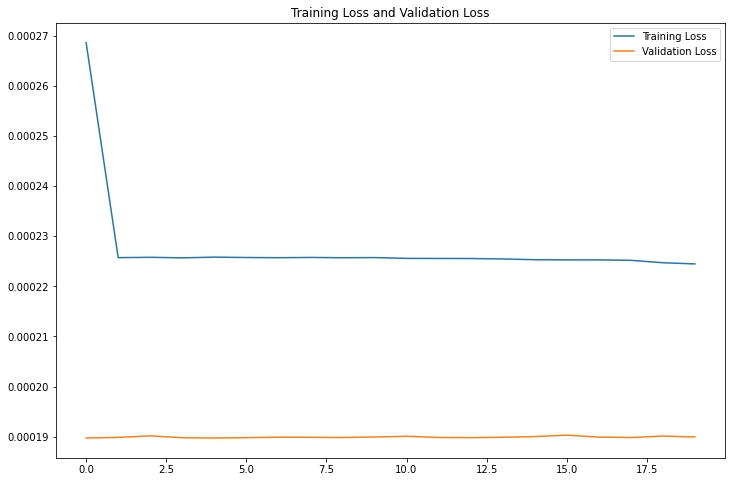

In [548]:
plot_history(history)

In [555]:
pred = model.predict(X_train)

In [556]:
averaged_predictions = []
for i in range(pred.shape[0]):
    out_ix = i+4
    if out_ix >= pred.shape[0]:
        break
    
    pred0 = pred[i:out_ix][0][3]
    pred1 = pred[i:out_ix][1][2]
    pred2 = pred[i:out_ix][2][1]
    pred3 = pred[i:out_ix][3][0]
    
    pred_sum = pred0 + pred1 + pred2 + pred3
    pred_avg = pred_sum / 4
    
    averaged_predictions.append(pred_avg)

In [557]:
actual = y_train[-len(averaged_predictions):]
actual = [ar[3] for ar in actual]

In [558]:
actual_df = pd.DataFrame(np.array(actual), columns=open_df_train.columns)
avgpred_df = pd.DataFrame(np.array(averaged_predictions), columns=open_df_train.columns)

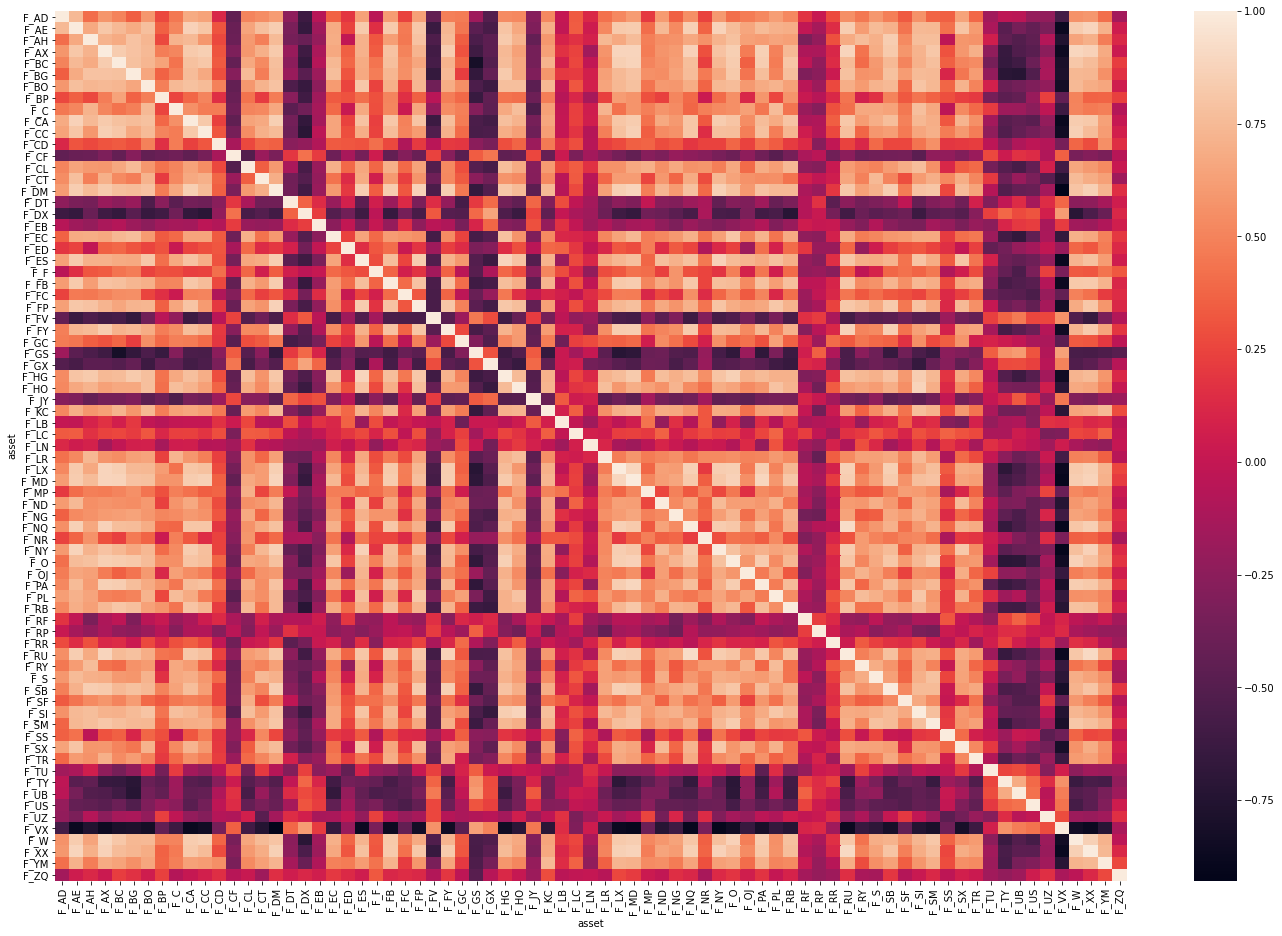

In [559]:
avgpred_cormat = avgpred_df.corr()
plt.figure(figsize=(24,16))
sns.heatmap(avgpred_cormat);

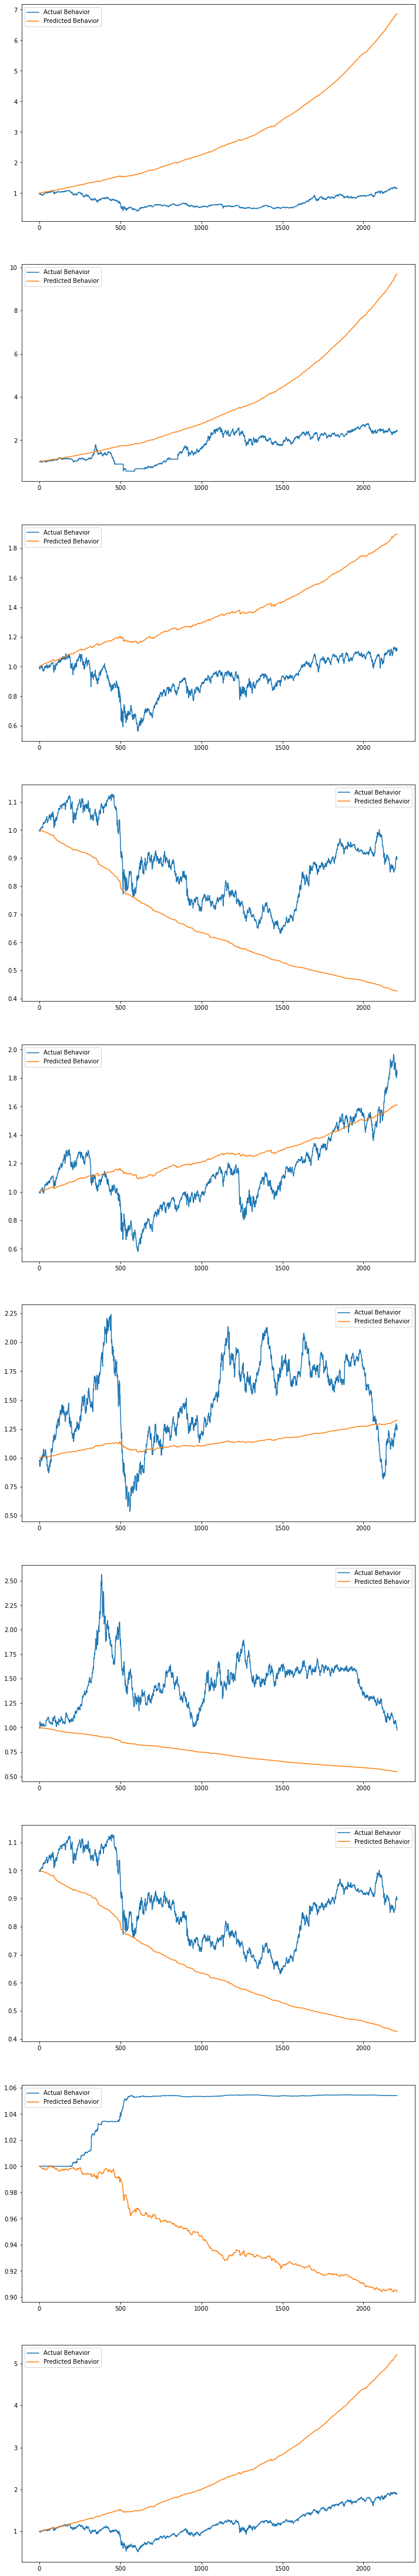

In [565]:
random_columns = np.random.randint(0, len(avgpred_df.columns), 10)

plt.figure(figsize=(12,80))

for i in range(0, len(random_columns)):
    col = random_columns[i]
    
    plt.subplot(10,1,i+1)
    plt.plot((1+actual_df.iloc[:,col]).cumprod(), label='Actual Behavior')
    plt.plot((1+avgpred_df.iloc[:,col]).cumprod(), label='Predicted Behavior')
    plt.legend()

## Use Predictions to Calculate Optimal Portfolios (Highest Sharpe Ratio) and Check Trading Performance

The idea in this part is to use the prediction from the model as the expected return and the price data from the previous 10 days to find the covariance matrix and calculate the weights for the portfolio with the highest Sharpe ratio. The model need not predict returns perfectly; it should be enough for it to capture the relationship between returns.

In [599]:
avgpred_df.index = open_df_train.iloc[-2209:,:].index

In [696]:
pred_ret = avgpred_df.iloc[0:4,:]
pred_ret

asset,F_AD,F_AE,F_AH,F_AX,F_BC,F_BG,F_BO,F_BP,F_C,F_CA,...,F_TU,F_TY,F_UB,F_US,F_UZ,F_VX,F_W,F_XX,F_YM,F_ZQ
time,,,,,,,,,,,,,,,,,,,,,
2006-10-26,-0.000573,0.000344,0.000101,0.000256,-0.000130,0.000501,0.000384,-0.000577,-0.000579,0.000451,...,0.000152,0.000100,-0.000179,0.001161,0.000239,-0.000854,-0.001309,0.000258,0.000339,-0.000108
2006-10-27,-0.000572,0.000336,0.000082,0.000213,-0.000166,0.000439,0.000393,-0.000594,-0.000548,0.000419,...,0.000197,0.000129,-0.000145,0.001189,0.000208,-0.000825,-0.001342,0.000210,0.000312,-0.000135
2006-10-30,-0.000583,0.000385,0.000168,0.000609,0.000093,0.000768,0.000314,-0.000458,-0.000723,0.000580,...,-0.000059,-0.000105,-0.000404,0.000962,0.000328,-0.001093,-0.000996,0.000581,0.000460,-0.000016
2006-10-31,-0.000568,0.000408,0.000166,0.000595,0.000101,0.000809,0.000344,-0.000474,-0.000792,0.000645,...,-0.000106,-0.000068,-0.000378,0.000966,0.000347,-0.001033,-0.001028,0.000569,0.000487,0.000013


In [690]:
price_df = open_df.dropna()

In [697]:
cov_prices = price_df[:'2006-10-25'].iloc[-11:]
cov_prices = cov_prices.pct_change().dropna()
cov_prices = cov_prices.append(pred_ret)

In [698]:
expret_pred = cov_prices.mean()
covmat_pred = cov_prices.cov()

In [700]:
covmat_array = np.array(covmat_pred)
expret_array = np.array(expret_pred)
ones_array = np.array([1] * covmat_pred.shape[0])

covmat_array_inv = la.inv(covmat_array)

In [701]:
top = covmat_array_inv @ expret_array
bottom = ones_array.T @ covmat_array_inv @ expret_array
opt_weights = top/bottom
opt_weights

array([-9.21283321e-02,  2.50566163e-02, -2.33928120e-02,  1.22679529e-01,
       -7.08932271e-04,  2.64308194e-02,  7.79700512e-03, -3.73780048e-02,
       -3.78487117e-02, -1.08467342e-01,  2.03614054e-02,  7.40613811e-02,
        3.27961892e-01, -2.79809439e-03, -1.60533951e-02,  5.22017837e-02,
       -9.73075425e-01,  8.54532067e-02,  4.74516587e+00, -5.36253481e-02,
        2.04974784e+00,  3.57791407e-01, -3.05487733e-02, -2.96809063e-02,
        5.66092608e-02,  8.62838840e-02,  6.26330902e-01, -4.96557548e-02,
        4.57662685e-03, -3.89399130e-01,  8.13318879e-02,  2.76827492e-02,
       -4.09009022e-02,  1.20775397e-01, -3.37863282e-03, -1.96911780e-02,
        5.82651002e-02, -4.95239246e-03,  3.02824790e-02,  9.18781631e-02,
       -9.09794888e-03,  7.26401752e-02, -2.41765852e-02,  2.37079179e-03,
        3.11357532e-02,  1.97426800e-02, -4.80856822e-02, -5.04344683e-03,
        1.22977192e-02, -1.21493909e-03,  4.94670543e-02,  4.38256928e-02,
        1.14345210e-02, -

In [703]:
maxSharpe_return = opt_weights.T @ expret_array
maxSharpe_var = opt_weights.T @ covmat_array @ opt_weights
maxSharpe_vol = np.sqrt(maxSharpe_var)
maxSharpe_sharpe = maxSharpe_return / maxSharpe_vol

In [761]:
maxSharpe_sharpe

26537815.214500483

In [825]:
pred_sharpes = []
optimal_weights = []
longterm_returns = []
for i in range(pred.shape[0]):
    out_ix = i+4
    if out_ix > pred.shape[0]:
        break
    pred_prices = pd.DataFrame(pred[i], columns=open_df_train.columns, index=open_df_train.index[i:out_ix])
    cov_prices = price_df[:pred_prices.index[0]][-12:-1].pct_change().dropna()
    cov_prices_with_pred = cov_prices.append(pred_prices)
    
    exp_ret = cov_prices_with_pred.mean()
    cov_mat = cov_prices_with_pred.cov()
    
    covmat_array = np.array(cov_mat)
    expret_array = np.array(exp_ret)
    ones_array = np.array([1] * cov_mat.shape[0])
    
    covmat_array_inv = la.inv(covmat_array)
    
    top = covmat_array_inv @ expret_array
    bottom = ones_array.T @ covmat_array_inv @ expret_array
    opt_weights = top / bottom
    
    optimal_weights.append(opt_weights)
    
    maxSharpe_return = opt_weights.T @ expret_array
    maxSharpe_var = abs(opt_weights.T @ covmat_array @ opt_weights)
    maxSharpe_vol = np.sqrt(maxSharpe_var)
    maxSharpe_sharpe = maxSharpe_return / maxSharpe_vol
    
    pred_sharpes.append(maxSharpe_sharpe)
    
    actual_pct = price_df[:pred_prices.index[0]][-2:].pct_change().dropna()
    port_ret = opt_weights.T @ np.array(actual_pct).reshape((75,))
    longterm_returns.append(port_ret)

## Try something else

How about this idea...we have the data split into 2-week periods...so let's use the maximum Sharpe portfolio weights from those two weeks PLUS the next day as the target.